In [15]:
import gdown
import os

In [16]:
# 파일 ID 추출
file_id = "1-4LeXHvCtCvx3k4fgfjVRznulnGU6Hmx"
# 다운로드 링크 생성
download_url = f"https://drive.google.com/uc?id={file_id}"

In [17]:
# 파일 다운로드
output_file = "Yolo_v3.pth"

In [18]:
# 파일 다운로드
if not os.path.exists(output_file):
    gdown.download(download_url, output_file, quiet=False)
    print("다운로드 완료")
else:
    print("파일이 이미 존재함")

파일이 이미 존재함


In [19]:
import torch
from darknet53_FPN import Darknet53
from Yolov3_model import YOLOv3, FPN

In [20]:
backbone = Darknet53(pretrained=False)
fpn = FPN(channels_list=[256, 512, 1024])

# yolo v3 모델 로드
model = YOLOv3(backbone, fpn, num_classes=80)

# 로드한 yolo v3에 학습된 가중치 로드
model.load_weights("Yolo_v3_down.pth")

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from yolo_v3_nms import Yolov3NMS

In [29]:
# 이미지 불러오기 및 전처리
image_path = "10101.jpg" #여기에 추론하고 싶은 이미지 경로 기입
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (416, 416))
image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).unsqueeze(0).float() / 255.0

In [30]:
# 모델 추론
with torch.no_grad():
    outputs = model(image_tensor)

# NMS 적용
nms = Yolov3NMS(conf_th=0.9)
boxes = nms.non_max_suppression(outputs)

# # 추출된 bbox정보 display
# for box in boxes:
#     print(box)


In [24]:
# 슈퍼 클래스와 해당 색상 매핑
cls_color = {
    "person": "magenta",
    "vehicle": "yellow",
    "outdoor": "blue",
    "animal": "green",
    "accessory": "purple",
    "sports": "orange",
    "kitchen": "brown",
    "food": "red",
    "furniture": "cyan",
    "electronic": "pink",
    "appliance": "lime",
    "indoor": "gray"
}

# COCO 클래스 레이블을 슈퍼 클래스에 따라 그룹화한 딕셔너리
coco_map = {
    "person": [0],
    "vehicle": [1, 2, 3, 4, 5, 6, 7],
    "outdoor": [8, 9, 10, 11, 12, 13],
    "animal": [14, 15, 16, 17, 18, 19, 20, 21, 22],
    "accessory": [23, 24, 25, 26, 27],
    "sports": [28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
    "kitchen": [38, 39, 40, 41, 42, 43, 44],
    "food": [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
    "furniture": [56, 57, 58],
    "electronic": [59, 60, 61, 62, 63, 64],
    "appliance": [65, 66, 67, 68],
    "indoor": [69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
}

# COCO 클래스 레이블
coco_label = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
    "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase",
    "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle",
    "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet",
    "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave",
    "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
]

In [25]:
# 클래스 ID를 슈퍼 클래스 이름으로 매핑
cls_map = {cls_id: superclass for superclass, cls_ids in coco_map.items() for cls_id in cls_ids}

In [26]:
# 결과 시각화 함수
def plot_boxes(image, boxes, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box in boxes:
        x1, y1, x2, y2, conf, label = box
        w = x2 - x1
        h = y2 - y1
        label = int(label)
        superclass = cls_map[label]
        color = cls_color[superclass]

        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        plt.text(x1, y1, s=labels[label], color='white', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

    plt.axis('off')
    plt.show()

In [27]:
# 원본 이미지로 시각화하기 위해 박스 좌표를 원래 이미지 크기로 변환
scale_x = image.shape[1]
scale_y = image.shape[0]

boxes = [[box[0] * scale_x, 
          box[1] * scale_y, 
          box[2] * scale_x, 
          box[3] * scale_y, 
          box[4], box[5]] for box in boxes]



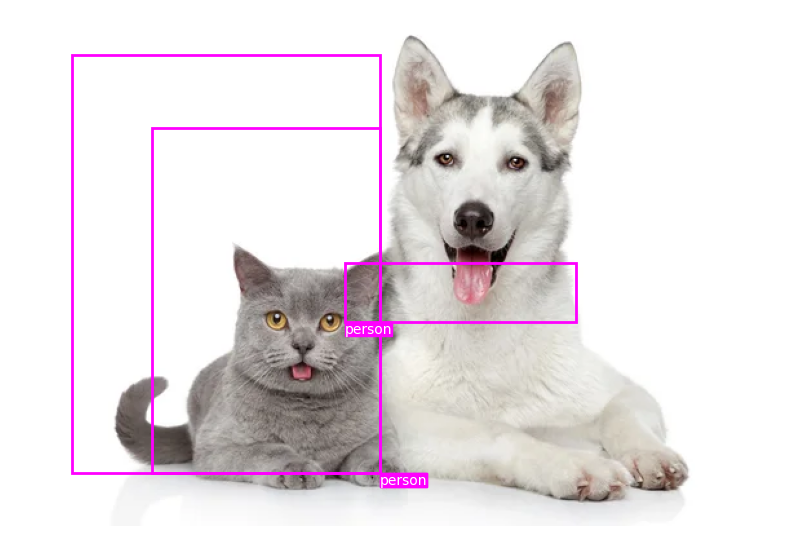

In [28]:
# 결과 시각화
plot_boxes(image_rgb, boxes, coco_label)